# Template for hackathon projects

This notebook simulates a generic ground experiment in a way that can be easily customized for your project

In [1]:
import os
import sys

import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import toast
import toast.pipeline_tools
from toast.mpi import MPI


# Are you using a special reservation for a workshop?
# If so, set it here:
nersc_reservation = None

# Load common tools for all lessons
import sys
sys.path.insert(0, "../lessons")
from lesson_tools import (
    check_nersc,
    fake_focalplane
)
nersc_host, nersc_repo, nersc_resv = check_nersc(reservation=nersc_reservation)

# Capture C++ output in the jupyter cells
%reload_ext wurlitzer

! [[ ! -e weather_Atacama.fits ]] && wget http://portal.nersc.gov/project/cmb/toast_data/example_data/weather_Atacama.fits

Not running at NERSC, slurm jobs disabled.


## Parameters

These arguments control the entire notebook

In [2]:
class args:
    split_schedule = None
    schedule = "schedule.txt"
    sort_schedule = False  # Matters for parallelization
    weather = "weather_Atacama.fits"
    sample_rate = 10  # Hz
    # Noise parameters
    fknee = 1.0
    alpha = 2
    # Scanning parameters
    scan_rate = 1.0  # deg / s
    scan_accel = 1.0  # deg / s^2
    # half-wave plate
    hwp_rpm = None
    hwp_step_deg = None
    hwp_step_time_s = None
    fov = 3.0  # Field-of-view in degrees
    # Projection parameters
    coord = "C"
    nside = 64
    mode = "IQU"
    outdir = "maps"

## Observing schedule

We write the scheduler parameters to file.  These arguments produce one constant elevation scan but you can easily modify that.

In [3]:
%%writefile schedule.par
--site-lat
-22.958064
--site-lon
-67.786222
--site-alt
5200
--site-name
Atacama
--telescope
LAT
--start
2020-01-01 00:00:00
--stop
2020-01-02 00:00:00
--patch-coord
C
--patch
small_patch,1,40,-40,10
--ces-max-time
86400
--out
schedule.txt

Overwriting schedule.par


Now run the scheduler.  The observing schedule will end up in `schedule.txt`.

In [4]:
! toast_ground_schedule.py @schedule.par

TOAST INFO: Adding patch "small_patch"
TOAST INFO: Center-and-width format
TOAST INFO: Global timer: toast_ground_schedule:  0.14 seconds (1 calls)


## Focalplane

In [5]:
focalplane = toast.pipeline_tools.Focalplane(
    fake_focalplane(fov=args.fov, fknee=args.fknee, alpha=args.alpha),
    sample_rate=args.sample_rate, 
)

## TODGround to `toast.data`

In [6]:
mpiworld, procs, rank = toast.mpi.get_world()
comm = toast.mpi.Comm(mpiworld)

# Load the observing schedule, append weather and focalplane to it
    
schedules = toast.pipeline_tools.load_schedule(args, comm)
toast.pipeline_tools.load_weather(args, comm, schedules)
# There could be more than one observing schedule, but not this time
schedule = schedules[0]
schedule.telescope.focalplane = focalplane

# Useful shorthands in what follows
telescope = schedule.telescope
site = telescope.site

# Create TODGround objects based on the entries in the schedule
    
data = toast.Data(comm)

for ces in schedule.ceslist:
    totsamples = int((ces.stop_time - ces.start_time) * args.sample_rate)

    tod = toast.todmap.TODGround(
        comm.comm_group,
        focalplane.detquats,
        totsamples,
        detranks=(1 if comm.comm_group is None else comm.comm_group.size),
        firsttime=ces.start_time,
        rate=args.sample_rate,
        site_lon=site.lon,
        site_lat=site.lat,
        site_alt=site.alt,
        azmin=ces.azmin,
        azmax=ces.azmax,
        el=ces.el,
        scanrate=args.scan_rate,
        scan_accel=args.scan_accel,
        coord=args.coord,
        hwprpm=args.hwp_rpm,
        hwpstep=args.hwp_step_deg,
        hwpsteptime=args.hwp_step_time_s,
    )
    
    # Now embed the TOD in an observation dictionary and add other necessary metadata

    obs = {}
    obs["name"] = "CES-{}-{}-{}-{}-{}".format(
        site.name, telescope.name, ces.name, ces.scan, ces.subscan
    )
    obs["tod"] = tod
    obs["noise"] = focalplane.noise
    obs["id"] = int(ces.mjdstart * 10000)
    obs["intervals"] = tod.subscans
    obs["site"] = site
    obs["site_name"] = site.name
    obs["site_id"] = site.id
    obs["altitude"] = site.alt
    obs["weather"] = site.weather
    obs["telescope"] = telescope
    obs["telescope_name"] = telescope.name
    obs["telescope_id"] = telescope.id
    obs["focalplane"] = focalplane.detector_data
    obs["fpradius"] = focalplane.radius
    obs["start_time"] = ces.start_time
    obs["season"] = ces.season
    obs["date"] = ces.start_date
    obs["MJD"] = ces.mjdstart
    obs["rising"] = ces.rising
    obs["mindist_sun"] = ces.mindist_sun
    obs["mindist_moon"] = ces.mindist_moon
    obs["el_sun"] = ces.el_sun
    
    # And append the observation to the list of observations
    
    data.obs.append(obs)

TOAST INFO: Load 8 (sub)scans in schedule.txt:  0.01 seconds (1 calls)
TOAST INFO: Loading schedule(s):  0.01 seconds (1 calls)
TOAST INFO: Load weather_Atacama.fits:  0.22 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.01 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.02 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.01 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.01 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.01 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointi

## Pointing matrix

Here we translate the boresight quaternions into detector pointing (pixels numbers and Stokes weights).

In [7]:
toast.todmap.OpPointingHpix(nside=args.nside, nest=True, mode=args.mode).exec(data)

Make a boolean hit map for diagnostics

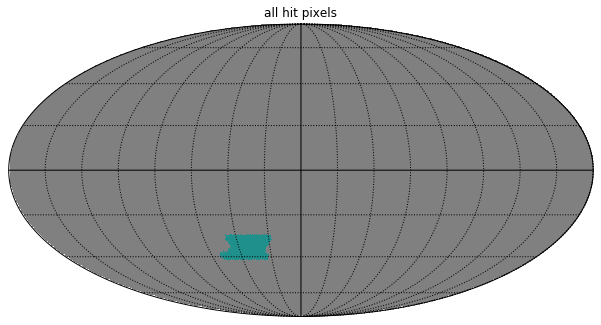

In [8]:
npix = 12 * args.nside ** 2
hitmap = np.zeros(npix)
for obs in data.obs:
    tod = obs["tod"]
    for det in tod.local_dets:
        pixels = tod.cache.reference("pixels_{}".format(det))
        hitmap[pixels] = 1
hitmap[hitmap == 0] = hp.UNSEEN
hp.mollview(hitmap, nest=True, title="all hit pixels", cbar=False)
hp.graticule(22.5, verbose=False)

## Sky signal

Create a synthetic Gaussian map to scan as input signal

Sigma is 382.194810 arcmin (0.111176 rad) 
-> fwhm is 900.000000 arcmin


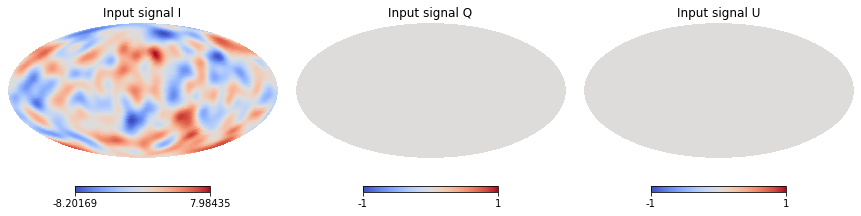

In [9]:
lmax = args.nside * 2
cls = np.zeros([4, lmax + 1])
cls[0] = 1e0
sim_map = hp.synfast(cls, args.nside, lmax=lmax, fwhm=np.radians(15), new=True)
plt.figure(figsize=[12, 8])
for i, m in enumerate(sim_map):
    hp.mollview(sim_map[i], cmap="coolwarm", title="Input signal {}".format("IQU"[i]), sub=[1, 3, 1+i])
hp.write_map("sim_map.fits", hp.reorder(sim_map, r2n=True), nest=True, overwrite=True)

Scan the sky signal

In [10]:
full_name = "signal"
sky_name = "sky_signal"

# Clear any lingering sky signal from the buffers
toast.tod.OpCacheClear(full_name).exec(data)

distmap = toast.map.DistPixels(
    data,
    nnz=len(args.mode),
    dtype=np.float32,
)
distmap.read_healpix_fits("sim_map.fits")
toast.todmap.OpSimScan(distmap=distmap, out=full_name).exec(data)

# Copy the sky signal, just in case we need it later

toast.tod.OpCacheCopy(input=full_name, output=sky_name, force=True).exec(data)

## Noise

Simulate noise and make a copy of signal+noise in case we need it later

In [11]:
copy_name = "signal_copy"

toast.tod.OpSimNoise(out=full_name, realization=0).exec(data)

toast.tod.OpCacheCopy(input=full_name, output=copy_name, force=True).exec(data)

## Your own operator here

Here we define an empty operator you can work with

In [12]:
class MyOperator(toast.Operator):
    def __init__(self, name="signal"):
        """ Arguments:
        name(str) : Cache prefix to operate on
        """
        self._name = name
    
    def exec(self, data):
        # We loop here over all local data but do nothing with it.
        for obs in data.obs:
            tod = obs["tod"]
            for det in tod.local_dets:
                signal = tod.local_signal(det, self._name)
                signal *= 2

Then we apply the operator to the data

In [13]:
toast.tod.OpCacheCopy(input=copy_name, output=full_name, force=True).exec(data)
MyOperator(name=full_name).exec(data)

Plot a short segment of the signal before and after the operator

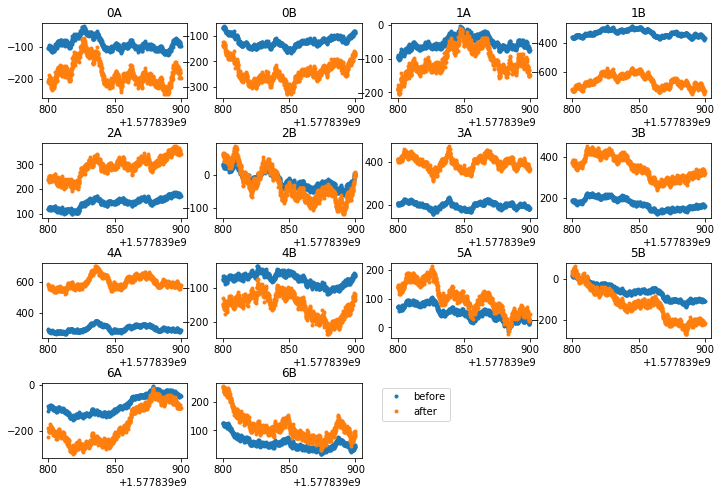

In [14]:
tod = data.obs[0]["tod"]
times = tod.local_times()

fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets):
    cflags = tod.local_common_flags()
    before = tod.local_signal(det, copy_name)
    after = tod.local_signal(det, full_name)

    ind = slice(0, 1000)
    # Flag out turnarounds
    good = (cflags[ind] & tod.TURNAROUND) == 0
    ax = fig.add_subplot(4, 4, 1 + idet)
    ax.set_title(det)
    ax.plot(times[ind][good], before[ind][good], '.', label="before")
    ax.plot(times[ind][good], after[ind][good], '.', label="after")
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=0.6)

## Make a map

Destripe the signal and make a map.  We use the nascent TOAST mapmaker because it can be run in serial mode without MPI.  The TOAST mapmaker is still significantly slower so production runs should used `libMadam`.

In [15]:
# Always begin mapmaking by copying the simulated signal.

destriped_name = "destriped"
toast.tod.OpCacheCopy(input=copy_name, output=destriped_name, force=True).exec(data)

mapmaker = toast.todmap.OpMapMaker(
    nside=args.nside,
    nnz=3,
    name=destriped_name,
    outdir=args.outdir,
    outprefix="toast_test_",
    baseline_length=10,
    iter_max=100,
    use_noise_prior=False,
)
mapmaker.exec(data)

TOAST INFO: Flag gaps:  0.01 seconds (1 calls)
TOAST INFO: Get detector weights:  0.01 seconds (1 calls)
TOAST INFO: Identify local submaps:  0.00 seconds (1 calls)
TOAST INFO: Accumulate N_pp'^1:  0.07 seconds (1 calls)
TOAST INFO: All reduce N_pp'^1:  0.00 seconds (1 calls)
TOAST INFO: Wrote hits to maps/toast_test_hits.fits
TOAST INFO: Write hits:  0.01 seconds (1 calls)
TOAST INFO: Wrote inverse white noise covariance to maps/toast_test_invnpp.fits
TOAST INFO: Write N_pp'^1:  0.02 seconds (1 calls)
TOAST INFO: Compute reciprocal condition numbers:  0.00 seconds (1 calls)
TOAST INFO: Wrote reciprocal condition numbers to maps/toast_test_rcond.fits
TOAST INFO: Write rcond:  0.01 seconds (1 calls)
TOAST INFO: Invert N_pp'^1:  0.00 seconds (1 calls)
TOAST INFO: Wrote white noise covariance to maps/toast_test_npp.fits
TOAST INFO: Write N_pp':  0.02 seconds (1 calls)
TOAST INFO:   Build noise-weighted map:  0.00 seconds (0 calls)
TOAST INFO:   Apply noise covariance:  0.00 seconds (0 cal

Plot a segment of the timelines

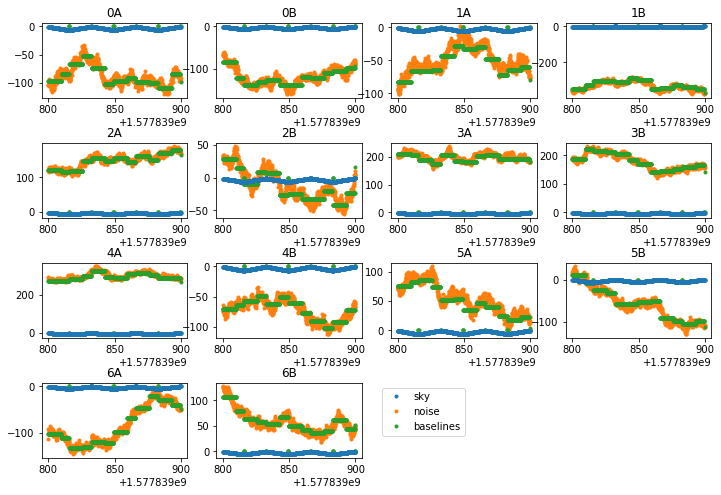

In [16]:
tod = data.obs[0]["tod"]
times = tod.local_times()

fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets):
    sky = tod.local_signal(det, sky_name)
    full = tod.local_signal(det, copy_name)
    destriped = tod.local_signal(det, destriped_name)

    ind = slice(0, 1000)
    ax = fig.add_subplot(4, 4, 1 + idet)
    ax.set_title(det)
    ax.plot(times[ind], sky[ind], '.', label="sky", zorder=100)
    ax.plot(times[ind], full[ind] - sky[ind], '.', label="noise")
    ax.plot(times[ind], full[ind] - destriped[ind], '.', label="baselines")
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=0.6)


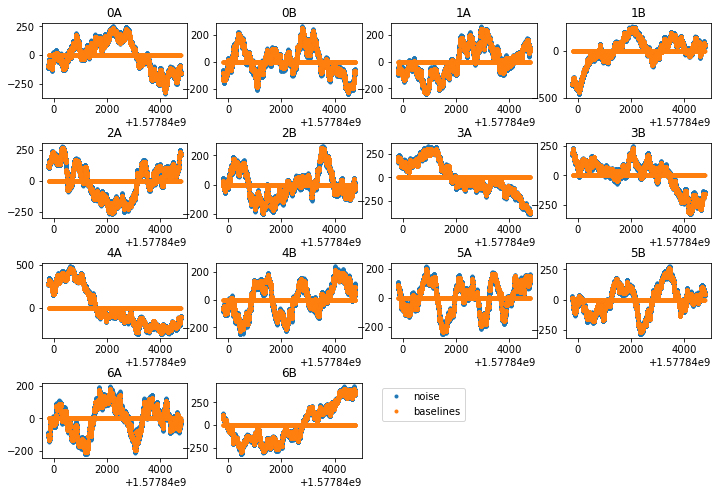

In [17]:
fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets):
    sky = tod.local_signal(det, sky_name)
    full = tod.local_signal(det, copy_name)
    destriped = tod.local_signal(det, destriped_name)
    ax = fig.add_subplot(4, 4, 1 + idet)
    ax.set_title(det)
    #plt.plot(times[ind], sky[ind], '-', label="signal", zorder=100)
    plt.plot(times, full - sky, '.', label="noise")
    plt.plot(times, full - destriped, '.', label="baselines")
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=.6)

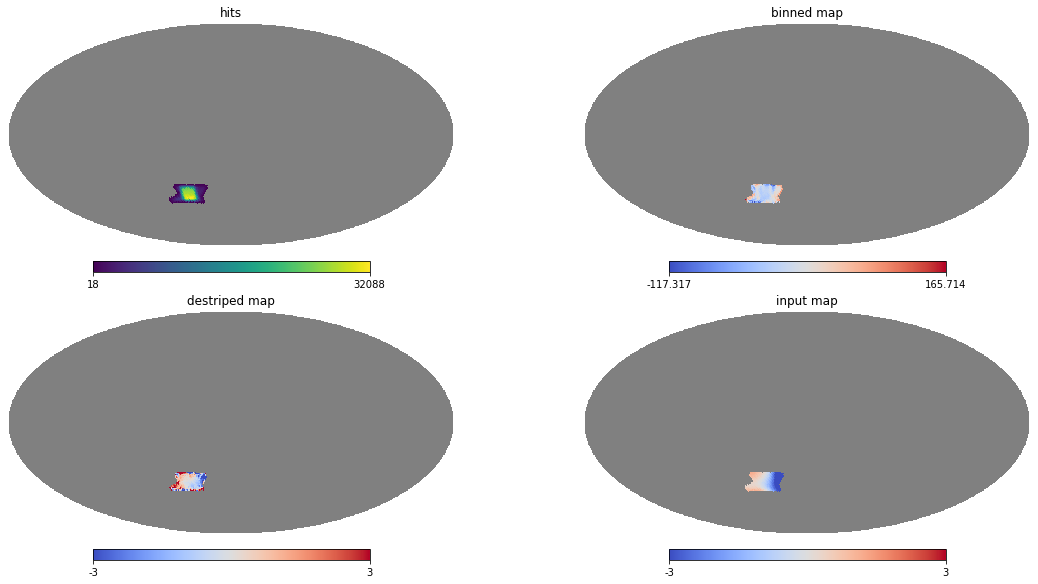

In [18]:
plt.figure(figsize=[16, 8])

hitmap = hp.read_map("maps/toast_test_hits.fits", verbose=False)
hitmap[hitmap == 0] = hp.UNSEEN
hp.mollview(hitmap, sub=[2, 2, 1], title="hits")

binmap = hp.read_map("maps/toast_test_binned.fits", verbose=False)
binmap[binmap == 0] = hp.UNSEEN
hp.mollview(binmap, sub=[2, 2, 2], title="binned map", cmap="coolwarm")

# Fix the plotting range for input signal and the destriped map
amp = 3.0

destriped = hp.read_map("maps/toast_test_destriped.fits", verbose=False)
destriped[destriped == 0] = hp.UNSEEN
# Remove monopole
good = destriped != hp.UNSEEN
destriped[good] -= np.median(destriped[good])
hp.mollview(destriped, sub=[2, 2, 3], title="destriped map", cmap="coolwarm", min=-amp, max=amp)

inmap = hp.read_map("sim_map.fits", verbose=False)
inmap[hitmap == hp.UNSEEN] = hp.UNSEEN
hp.mollview(inmap, sub=[2, 2, 4], title="input map", cmap="coolwarm", min=-amp, max=amp)


In [19]:
print(np.sum(hitmap[hitmap != hp.UNSEEN]) / 1400000.0)

2.7228


NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


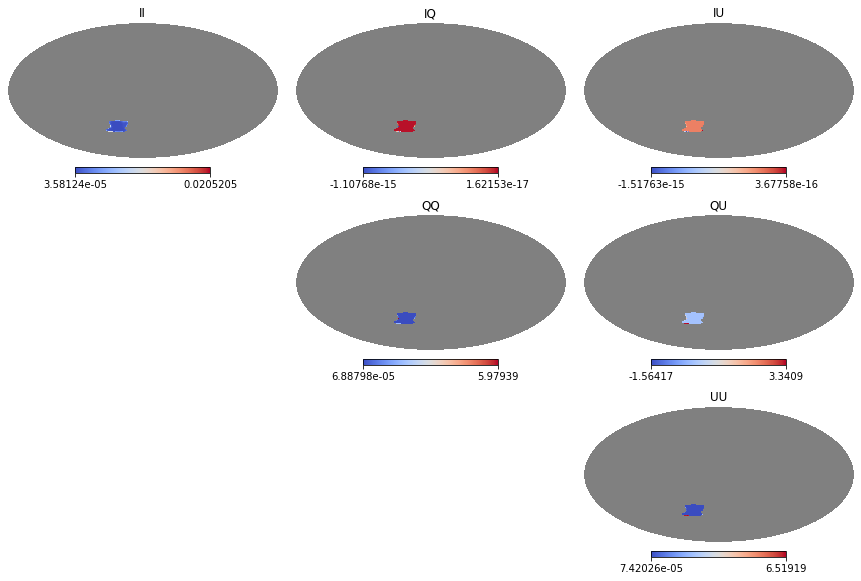

In [20]:
# Plot the white noise covariance

plt.figure(figsize=[12, 8])
wcov = hp.read_map("maps/toast_test_npp.fits", None)
wcov[:, wcov[0] == 0] = hp.UNSEEN
hp.mollview(wcov[0], sub=[3, 3, 1], title="II", cmap="coolwarm")
hp.mollview(wcov[1], sub=[3, 3, 2], title="IQ", cmap="coolwarm")
hp.mollview(wcov[2], sub=[3, 3, 3], title="IU", cmap="coolwarm")
hp.mollview(wcov[3], sub=[3, 3, 5], title="QQ", cmap="coolwarm")
hp.mollview(wcov[4], sub=[3, 3, 6], title="QU", cmap="coolwarm")
hp.mollview(wcov[5], sub=[3, 3, 9], title="UU", cmap="coolwarm")

## Filter & bin

A filter-and-bin mapmaker is easily created by combining TOAST filter operators and running the mapmaker without destriping:

TOAST INFO: Flag gaps:  0.01 seconds (1 calls)
TOAST INFO: Get detector weights:  0.00 seconds (1 calls)
TOAST INFO: Identify local submaps:  0.00 seconds (1 calls)
TOAST INFO: Accumulate N_pp'^1:  0.04 seconds (1 calls)
TOAST INFO: All reduce N_pp'^1:  0.00 seconds (1 calls)
TOAST INFO: Wrote hits to maps/toast_test_filtered_hits.fits
TOAST INFO: Write hits:  0.01 seconds (1 calls)
TOAST INFO: Wrote inverse white noise covariance to maps/toast_test_filtered_invnpp.fits
TOAST INFO: Write N_pp'^1:  0.03 seconds (1 calls)
TOAST INFO: Compute reciprocal condition numbers:  0.00 seconds (1 calls)
TOAST INFO: Wrote reciprocal condition numbers to maps/toast_test_filtered_rcond.fits
TOAST INFO: Write rcond:  0.01 seconds (1 calls)
TOAST INFO: Invert N_pp'^1:  0.01 seconds (1 calls)
TOAST INFO: Wrote white noise covariance to maps/toast_test_filtered_npp.fits
TOAST INFO: Write N_pp':  0.02 seconds (1 calls)
TOAST INFO:   Build noise-weighted map:  0.00 seconds (0 calls)
TOAST INFO:   Apply no

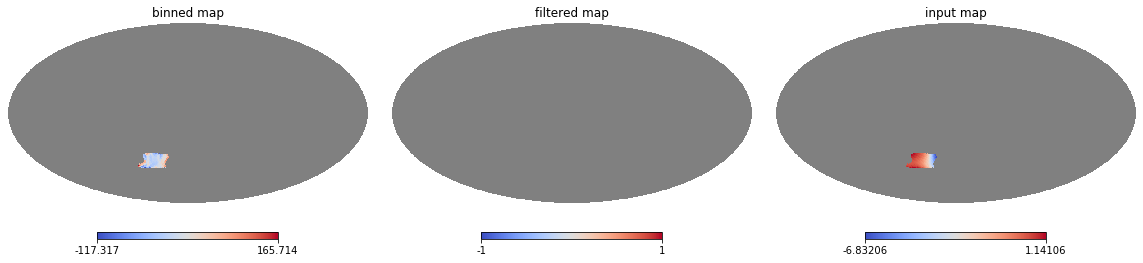

In [21]:
filtered_name = "filtered"

toast.tod.OpCacheCopy(input=copy_name, output=filtered_name, force=True).exec(data)

toast.tod.OpPolyFilter(order=3, name=filtered_name).exec(data)

mapmaker = toast.todmap.OpMapMaker(
    nside=args.nside,
    nnz=len(args.mode),
    name=filtered_name,
    outdir=args.outdir,
    outprefix="toast_test_filtered_",
    baseline_length=None,
)
mapmaker.exec(data)

plt.figure(figsize=[16, 8])

binmap = hp.read_map("maps/toast_test_binned.fits", verbose=False)
binmap[binmap == 0] = hp.UNSEEN
hp.mollview(binmap, sub=[1, 3, 1], title="binned map", cmap="coolwarm")

filtered_map = hp.read_map("maps/toast_test_filtered_binned.fits", verbose=False)
filtered_map[filtered_map == 0] = hp.UNSEEN
hp.mollview(filtered_map, sub=[1, 3, 2], title="filtered map", cmap="coolwarm")

inmap = hp.read_map("sim_map.fits", verbose=False)
inmap[binmap == hp.UNSEEN] = hp.UNSEEN
hp.mollview(inmap, sub=[1, 3, 3], title="input map", cmap="coolwarm")